Name:  WedOO.ai

Creation_date❎ 04/11/2021

Updata_date🐾 21/11/2021

Train using a GPU.

Before running the notebook you need to install the dependency *albumentations* (uncomment the installation command)

1. The installation will also require you to restart the notebook in some cases.
2. You also need to unzip the *dataset.zip* file to get access to all the dataset and our pretrained model. The aboration below shows how our zip file is structured

dataset--------:

|-----Train_Images.zip

|-----Test_Images.zip

|-----Train.csv

|-----Test.csv

|-----fasterrcnn_mob_train.pth

|-----Sample_submission.csv

In [3]:
#!pip install albumentations==0.4.6

In [ ]:
#!unzip "dataset.zip"      

In [ ]:
#importing necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import albumentations as alb
from albumentations.pytorch.transforms import ToTensorV2
import torch
from torch.utils.data import DataLoader,Dataset
from torch.utils.data import SubsetRandomSampler
import torchvision 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
import cv2
from tqdm.notebook import tqdm
import torch.nn as nn

## Preparing the Dataset

In [ ]:
path='dataset/' 
train_path=path+"Train.csv"
test_path=path+"Test.csv"

In [ ]:
##unzip folders
!unzip "dataset/Train_Images.zip"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Train_Images/ID_8ORN0O9Z.jpg  
  inflating: __MACOSX/Train_Images/._ID_8ORN0O9Z.jpg  
  inflating: Train_Images/ID_PALLHD0G.jpg  
  inflating: __MACOSX/Train_Images/._ID_PALLHD0G.jpg  
  inflating: Train_Images/ID_R7GF24Z5.jpg  
  inflating: __MACOSX/Train_Images/._ID_R7GF24Z5.jpg  
  inflating: Train_Images/ID_9JNXXBZH.jpg  
  inflating: __MACOSX/Train_Images/._ID_9JNXXBZH.jpg  
  inflating: Train_Images/ID_LDN6A4IZ.jpg  
  inflating: __MACOSX/Train_Images/._ID_LDN6A4IZ.jpg  
  inflating: Train_Images/ID_MP5TK8IN.jpg  
  inflating: __MACOSX/Train_Images/._ID_MP5TK8IN.jpg  
  inflating: Train_Images/ID_A6BF0RI8.jpg  
  inflating: __MACOSX/Train_Images/._ID_A6BF0RI8.jpg  
  inflating: Train_Images/ID_7ZL4ON97.jpg  
  inflating: __MACOSX/Train_Images/._ID_7ZL4ON97.jpg  
  inflating: Train_Images/ID_AMQA4BYT.jpg  
  inflating: __MACOSX/Train_Images/._ID_AMQA4BYT.jpg  
  inflating: Train_Images/ID_DT

In [ ]:
!unzip "dataset/Test_Images.zip"

Archive:  dataset/Test_Images.zip
   creating: Test_Images/
  inflating: __MACOSX/._Test_Images  
  inflating: Test_Images/ID_OAD1WBG0.jpg  
  inflating: __MACOSX/Test_Images/._ID_OAD1WBG0.jpg  
  inflating: Test_Images/ID_U6YW22OK.jpg  
  inflating: __MACOSX/Test_Images/._ID_U6YW22OK.jpg  
  inflating: Test_Images/ID_DE2BR633.jpg  
  inflating: __MACOSX/Test_Images/._ID_DE2BR633.jpg  
  inflating: Test_Images/ID_QUS1XC39.jpg  
  inflating: __MACOSX/Test_Images/._ID_QUS1XC39.jpg  
  inflating: Test_Images/ID_XTYQSAQ6.jpg  
  inflating: __MACOSX/Test_Images/._ID_XTYQSAQ6.jpg  
  inflating: Test_Images/ID_MUYXMWAI.jpg  
  inflating: __MACOSX/Test_Images/._ID_MUYXMWAI.jpg  
  inflating: Test_Images/ID_CPC4MQ9M.jpg  
  inflating: __MACOSX/Test_Images/._ID_CPC4MQ9M.jpg  
  inflating: Test_Images/ID_XWHGY1LA.jpg  
  inflating: __MACOSX/Test_Images/._ID_XWHGY1LA.jpg  
  inflating: Test_Images/ID_I8B8LA8C.jpg  
  inflating: __MACOSX/Test_Images/._ID_I8B8LA8C.jpg  
  inflating: Test_Images/ID_P

In [ ]:
train_img_path="Train_Images/"

In [ ]:
train = pd.read_csv(train_path)
train.head()

,Image_ID,class,xmin,ymin,width,height
0,ID_007FAIEI,fruit_woodiness,87.0,87.5,228.0,311.0
1,ID_00G8K1V3,fruit_brownspot,97.5,17.5,245.0,354.5
2,ID_00WROUT9,fruit_brownspot,156.5,209.5,248.0,302.5
3,ID_00ZJEEK3,fruit_healthy,125.0,193.0,254.5,217.0
4,ID_018UIENR,fruit_brownspot,79.5,232.5,233.5,182.0


In [ ]:
classes_la = {"fruit_brownspot": 1, "fruit_healthy": 2, "fruit_woodiness":3}

train["class"] = train["class"].apply(lambda x: classes_la[x])

In [ ]:
#append .jpg to image ids for easier handling
train['Image_ID'] = train['Image_ID'].apply(lambda x: str(x) + '.jpg')

In [ ]:
train['bbox_area'] = train['width']*train['height']

In [ ]:
#splitting into train and valid ids
train_split = 0.99

image_ids = train['Image_ID'].unique()
train_ids = image_ids[0:int(train_split*len(image_ids))]
val_ids = image_ids[int(train_split*len(image_ids)):]

print('Length of training ids', len(train_ids))
print('Length of validation ids', len(val_ids))

Length of training ids 2970
Length of validation ids 31


In [ ]:
train_df = train[train['Image_ID'].isin(train_ids)]
valid_df = train[train['Image_ID'].isin(val_ids)]

In [ ]:
class Passion_fruit_Dataset(Dataset):
    def __init__(self, df, image_dir,transform = None):
        super().__init__()
        self.df = df
        self.img_ids = df['Image_ID'].unique()
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx: int):
        image_id = self.img_ids[idx]
        pts = self.df[self.df['Image_ID'] == image_id]
        
        image = cv2.imread(os.path.join(self.image_dir, image_id), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.0
        
        boxes = pts[['xmin', 'ymin', 'width', 'height']].values
        
        #convert boxes to x1,y1,x2,y2 format because that is what resnet50 faster cnn in pytorch expects
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) #width times height
        area = torch.as_tensor(area, dtype = torch.float32)
        
        # there are 3 classes
        labels=pts["class"].values
        labels=torch.tensor(labels)
        #labels = torch.ones((pts.shape[0],), dtype=torch.int64)
        
        # background instance
        iscrowd = torch.zeros(len(classes_la), dtype=torch.int32) #(pts.shape[0],)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor(idx)
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transform:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transform(**sample)
            image = sample['image']
            
            if len(sample['bboxes']) > 0:
                target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            else:
                target['boxes'] = torch.linspace(0,3, steps = 4, dtype = torch.float32)
                target['boxes'] = target['boxes'].reshape(-1,4)
            
            #target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            #target['boxes'] = torch.as_tensor(sample['bboxes'], dtype=torch.float32)
            #target['boxes'] = torch.tensor(sample['bboxes'], dtype = torch.float32)
            
        return image, target, image_id

In [ ]:
#defining the transformations
def get_training_transforms():
    return alb.Compose([
    alb.VerticalFlip(p = 0.5),
    alb.HorizontalFlip(p = 0.5),
    alb.RandomBrightness(p = 1),
    alb.RandomContrast(p = 1),
    ToTensorV2(p = 1.0)
], p=1.0, bbox_params=alb.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_validation_transforms():
    return alb.Compose([ToTensorV2(p = 1.0)], p = 1.0, bbox_params = alb.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
# load a pre-trained model for classification and return
# only the features

densenet_net = torchvision.models.mobilenet_v2(pretrained=True)
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
modules = list(densenet_net.children())[:-1]
backbone = nn.Sequential(*modules)
backbone.out_channels = 1280# for densenet169 1664

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=4,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
#setting up dataloaders 
training_dataset = Passion_fruit_Dataset(train_df, train_img_path, get_training_transforms())
validation_dataset = Passion_fruit_Dataset(valid_df, train_img_path, get_validation_transforms())

train_dataloader = DataLoader(
        training_dataset, batch_size=2, shuffle= True, num_workers=4,
        collate_fn= collate_fn)

valid_dataloader = DataLoader(
        validation_dataset, batch_size=2, shuffle=False, num_workers=4,
        collate_fn=collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
device

device(type='cuda')

In [ ]:
images, targets, image_ids = next(iter(train_dataloader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1,2,0).cpu().numpy()

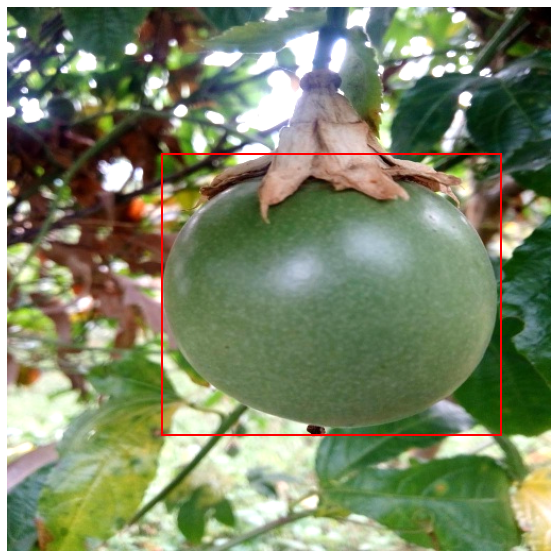

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for box in boxes:
    rect = patches.Rectangle((box[0],box[1]),box[2] - box[0],box[3] - box[1],linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
ax.set_axis_off()
ax.imshow(img)

In [ ]:
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr= 0.01, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

# and a learning rate scheduler
lr_scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True, threshold=0.0001, threshold_mode='abs', cooldown=0, min_lr=1e-8, eps=1e-08)
# let's train it for 10 epochs
num_epochs = 5

If you want to train the entire model once again, you need to uncomment the cell below (the training takes approximately 1h30mins)

In [2]:
#total_train_loss = []
#total_test_loss = []
#itr = 1

#for epoch in range(num_epochs):
#    model.train()

#    print('Epoch: ', epoch + 1)
#    train_loss = []
    
#    for images, targets, image_ids in tqdm(train_dataloader):
#        images = list(image.to(device) for image in images)
#        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
#        loss_dict = model(images, targets)  
#        losses = sum(loss for loss in loss_dict.values())
#        loss_value = losses.item()
#        train_loss.append(loss_value)
        
#        optimizer.zero_grad()
#        losses.backward()
#        optimizer.step()
        
        
        
#    epoch_loss = np.mean(train_loss)
#    print('Epoch Loss is: ' , epoch_loss)
#    total_train_loss.append(epoch_loss)
    
#    with torch.no_grad():
#        test_losses = []
#        for images, targets, image_ids in tqdm(valid_dataloader):
#            images = list(image.to(device) for image in images)
#            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
#            loss_dict = model(images, targets)

#            losses = sum(loss for loss in loss_dict.values())
#            test_loss = losses.item()
#            test_losses.append(test_loss)
            
#    test_losses_epoch = np.mean(test_losses)
#    print('Test Loss: ' ,test_losses_epoch)
#    total_test_loss.append(test_losses_epoch)
    
#    if lr_scheduler is not None:
#        lr_scheduler.step(test_losses_epoch)
        
#torch.save(model.state_dict(), 'fasterrcnn.pth')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Inferences

In [ ]:
# the list contain the path to our saved model initialy it was stored in google drive
paths=["dataset/fasterrcnn_mob_train.pth"]

In [ ]:
class Passion_fruit_Dataset_Test(Dataset):
    def __init__(self, df, image_dir,transform = None):
        super().__init__()
        self.df = df
        self.img_ids = df['Image_ID'].unique()
        self.image_dir = image_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx: int):
        image_id = self.img_ids[idx]
        pts = self.df[self.df['Image_ID'] == image_id]
        
        image = cv2.imread(os.path.join(self.image_dir, image_id+".jpg"), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image = image/255.0
        
        if self.transform:
            sample = {
                'image': image
            }
            sample = self.transform(**sample)
            image = sample['image']
            
        return image,image_id

In [ ]:
def get_test_transforms():
    return alb.Compose([ToTensorV2(p = 1.0)], p = 1.0)

getting access to our pretrained model for Inference

*Example*

model.load_state_dict(torch.load(path_of_pretrained_model,map_location=torch.device('cpu')))


When running the cell below, a *csv* file called *koubrah_fasterrcnn_mob_train* will be created automatically

In [ ]:
for path_of_model in paths:
  model = FasterRCNN(backbone,
                   num_classes=4,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)
  model.load_state_dict(torch.load(path_of_model,map_location=torch.device('cpu')))
  model.eval()
  if torch.cuda.is_available():
    model.cuda()
  test_img_path="Test_Images/"
  submit=pd.read_csv('dataset/Sample_submission.csv')
  test_dataset=Passion_fruit_Dataset_Test(submit,test_img_path,get_test_transforms())
  data=pd.read_csv('dataset/Sample_submission.csv')
  results=[]
  for j in range(0,data.shape[0]):
    img,_ = test_dataset[j]
    img = img.unsqueeze_(0)
    model.eval()
    
    with torch.no_grad():
      prediction = model([img.to(device)][0])
      thresh = 0   #with 0.4, we have 931 unique id's
      box_preds = prediction[0]['boxes'].cpu().detach().numpy()
      score_preds = prediction[0]['scores'].cpu().detach().numpy()
      labels=prediction[0]['labels'].cpu().detach().numpy()
      box_preds = box_preds[score_preds >= thresh].astype(np.float32)
      score_preds=score_preds[score_preds >= thresh]
      labels=labels[:len(score_preds)]
      aa = zip(box_preds.tolist(), labels.tolist(), score_preds.tolist())
      
      for item in list(aa):
        row_dict = {}
        row_dict["Image_ID"] = _
        row_dict["boxes"] = item[0]
        row_dict["labels"] = item[1]
        row_dict["confidence"] = item[2]
        results.append(row_dict)
    sub_df = pd.DataFrame(results)

  sub_df["ymin"] = sub_df["boxes"].apply(lambda x: x[1])
  sub_df["xmin"] = sub_df["boxes"].apply(lambda x: x[0])
  sub_df["ymax"] = sub_df["boxes"].apply(lambda x: x[3])
  sub_df["xmax"]=  sub_df["boxes"].apply(lambda x: x[2])

  classes_la = {0:"Background", 1:"fruit_brownspot", 2:"fruit_healthy", 3:"fruit_woodiness"}
  sub_df["labels"] = sub_df["labels"].apply(lambda x: classes_la[x])
  sub_df.drop(["boxes"], axis=1, inplace=True)
  sub_df.rename(columns={"labels":"class"}, inplace=True)
  sub_df.to_csv("koubrah_"+path[:-4]+".csv", index=False)

In [ ]:
#model.load_state_dict(torch.load("drive/MyDrive/fasterrcnn_mob_train.pth",map_location=torch.device('cpu')))
#model.eval()

In [ ]:
#def get_test_transforms():
#    return alb.Compose([ToTensorV2(p = 1.0)], p = 1.0)

In [ ]:
#if torch.cuda.is_available():
#    model.cuda()

In [ ]:
#images, targets, image_ids in next(iter(valid_dataloader))
#images = list(image.to(device) for image in images)
#targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#images

#prediction = model(images)

In [ ]:
#fig, ax = plt.subplots(1,2, figsize = (20,10))
#boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
#img = images[0].permute(1,2,0).cpu().numpy()

#for box in boxes:
#    rect = patches.Rectangle((box[0],box[1]),box[2] - box[0],box[3] - box[1],linewidth=2,edgecolor='r',facecolor='none')
#    ax[0].add_patch(rect)
#ax[0].set_title('Actual')
#ax[0].set_axis_off()
#ax[0].imshow(img)

#thresh = 0.5
#box_preds = prediction[0]['boxes'].cpu().detach().numpy()
#score_preds = prediction[0]['scores'].cpu().detach().numpy()
#box_preds = box_preds[score_preds >= thresh].astype(np.int32)
#for box in box_preds:
#    rect = patches.Rectangle((box[0],box[1]),box[2] - box[0],box[3] - box[1],linewidth=2,edgecolor='r',facecolor='none')
#    ax[1].add_patch(rect)
#ax[1].set_title('Predicted')
#ax[1].set_axis_off()
#ax[1].imshow(img)

In [ ]:
#test_img_path="Test_Images/"
#submit=pd.read_csv('dataset/Sample_submission.csv')

In [ ]:
#test_dataset=Passion_fruit_Dataset_Test(submit,test_img_path,get_test_transforms())

In [ ]:
#from google.colab.patches import cv2_imshow
#import matplotlib
#import matplotlib.pyplot as plt

In [ ]:
#fig,ax = plt.subplots(figsize = (20,10))
#img,_ = test_dataset[202]
#img = img.unsqueeze_(0)
#print(_)
#ax.imshow(img)
#print(img)
# put the model in evaluation mode
#model.eval()

#with torch.no_grad():
#  prediction = model([img.to(device)][0])
#  thresh = 0.5
#  box_preds = prediction[0]['boxes'].cpu().detach().numpy()
#  score_preds = prediction[0]['scores'].cpu().detach().numpy()
#  labels=prediction[0]['labels'].cpu().detach().numpy()
#  box_preds = box_preds[score_preds >= thresh].astype(np.float32)
#  score_preds=score_preds[score_preds >= thresh]
#  labels=labels[:len(score_preds)]
#  aa = zip(box_preds.tolist(), labels.tolist(), score_preds.tolist())
  

#  for box in box_preds:
#    rect = patches.Rectangle((box[0],box[1]),box[2] - box[0],box[3] - box[1],linewidth=2,edgecolor='r',facecolor='none')
#    ax.add_patch(rect)
#    #plt.show()
#  ax.imshow(img.squeeze().permute(1,2,0))